In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import joblib
import os
from utils import one_hot_encode_columns, train_rf_with_gridsearch
from scipy.stats import norm

In [2]:
anes_survey = 'anes_preprocessed_data.csv'
anes_df = pd.read_csv(anes_survey, low_memory=False)

anes_df = anes_df[['date', 'state', 'gender', 'race', 'age_group', 'edu', 'income', 'vote', 
                   'Yahoo', 'CNN', 'New York Times', 'Breitbart', 'Fox', 'Washington Post',
                   'The Guardian', 'USA Today', 'BBC', 'NPR', 'Buzzfeed']]

# perform one-hot encoding on the categorical column
categorical_columns = ['state', 'gender', 'race']
anes_df = one_hot_encode_columns(anes_df, categorical_columns)

In [3]:
anes_df[:3]

,date,age_group,edu,income,vote,Yahoo,CNN,New York Times,Breitbart,Fox,...,Wyoming,Female,Male,Sex_Refused,Asian/PI (Non-Hisp.),Black (Non-Hisp.),Hispanic,Multiple (Non-Hisp.),Other (Non-Hisp.),White (Non-Hisp.)
0,2020-08-27,4.0,6,21,2,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2020-08-18,4.0,2,17,1,1,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2020-10-12,4.0,4,7,1,0,0,0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X = anes_df.drop(['date','vote'], axis=1)
y = anes_df['vote']

In [5]:
# 80% train+val, 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 25% of 80% = 20% val
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
print(f"Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}")

Training set size: (3903, 75), Validation set size: (1301, 75), Test set size: (1301, 75)


In [6]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features':[3 ,5, 7, 9, 11],
    'max_depth': [3, 5, 7],
    'min_samples_split': [3, 5, 7, 10],
    'min_samples_leaf': [3, 5, 7]
}

best_rf, feature_importance, val_report, best_params = train_rf_with_gridsearch(X_train, y_train, X_val, y_val, param_grid)

Fitting 2 folds for each of 540 candidates, totalling 1080 fits


[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=3, min_samples_split

In [7]:
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 100}


In [8]:
val_report_df = pd.DataFrame(val_report).T
val_report_df

,precision,recall,f1-score,support
1,0.773635,0.783019,0.778299,742.00000
2,0.707273,0.695886,0.701533,559.00000
accuracy,0.745580,0.745580,0.745580,0.74558
macro avg,0.740454,0.739452,0.739916,1301.00000
weighted avg,0.745121,0.745580,0.745315,1301.00000


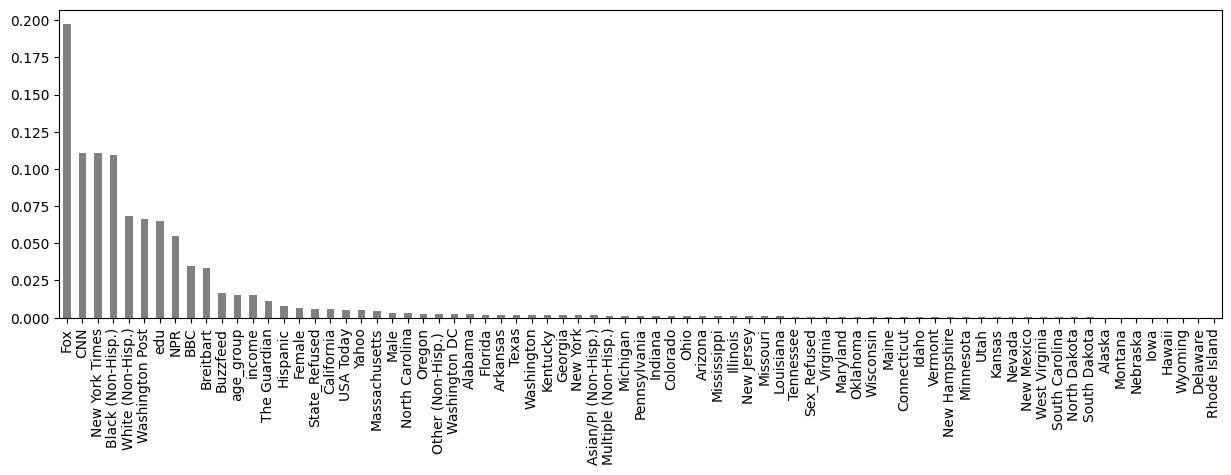

In [9]:
feature_importance.plot(kind='bar', figsize=(15, 4), color='gray')
plt.show()

In [10]:
# Save model
os.makedirs('models', exist_ok=True)
joblib.dump(best_rf, 'models/news_usage_model.pkl')

['models/news_usage_model.pkl']

In [11]:
# Noise Check
# 1. Shuffle y_val to introduce noise and evaluate model's predictions
y_val_shuffled = shuffle(y_val, random_state=42)
y_pred_val_shuffled = best_rf.predict(X_val)
shuffled_acc_val = accuracy_score(y_val_shuffled, y_pred_val_shuffled)
print(f"Shuffled Validation Accuracy: {shuffled_acc_val:.4f}")

Shuffled Validation Accuracy: 0.5273


In [12]:
# 2. Shuffle y_train to simulate training with noise
y_train_shuffled = shuffle(y_train, random_state=42)

# 3. Retrain the model with shuffled y_train
best_rf.fit(X_train, y_train_shuffled)

# 4. Feature importance from model trained on noisy data
feature_importance_shuffled = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feature_importance_shuffled = feature_importance_shuffled.sort_values(ascending=False)

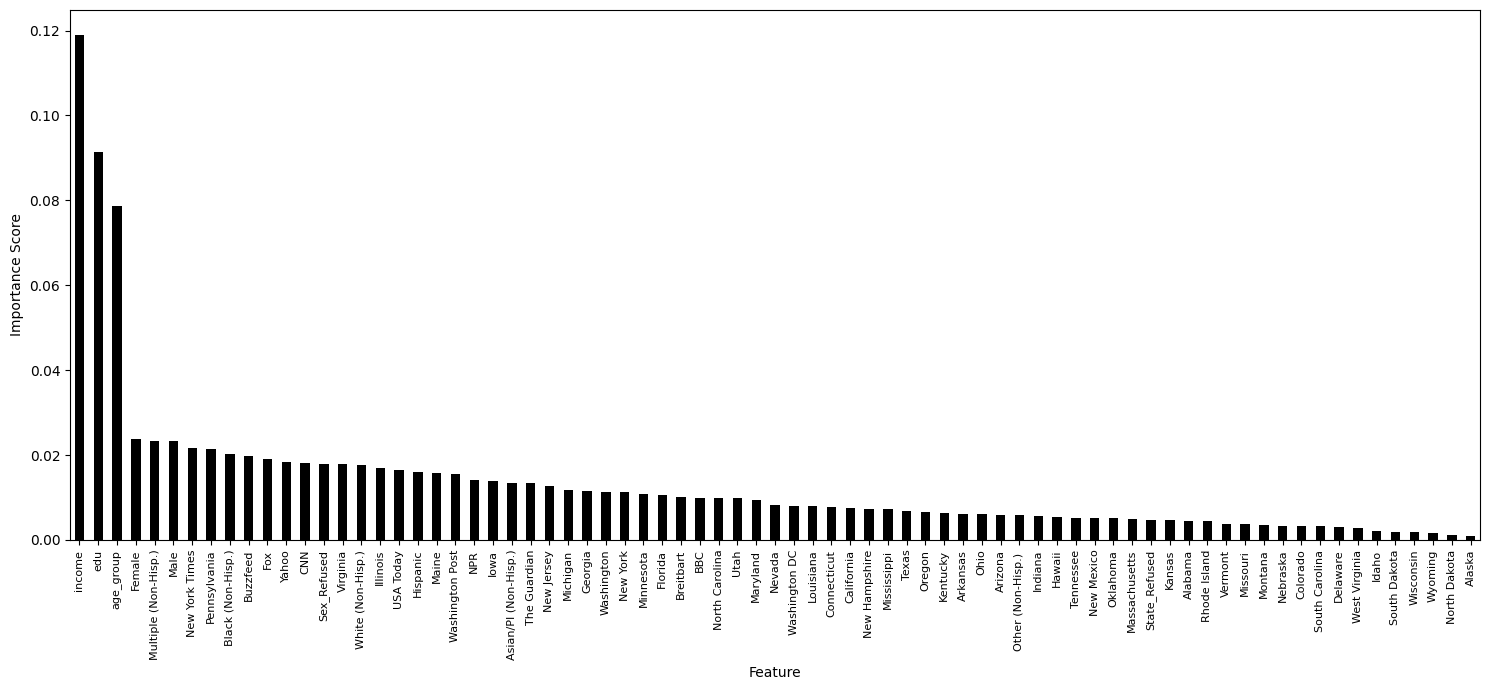

In [13]:
# 5. Plot feature importance after training on shuffled y_train
plt.figure(figsize=(15, 7))
feature_importance_shuffled.plot(kind='bar', color='black')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.xticks(fontsize=8)
plt.tight_layout()
plt.show()

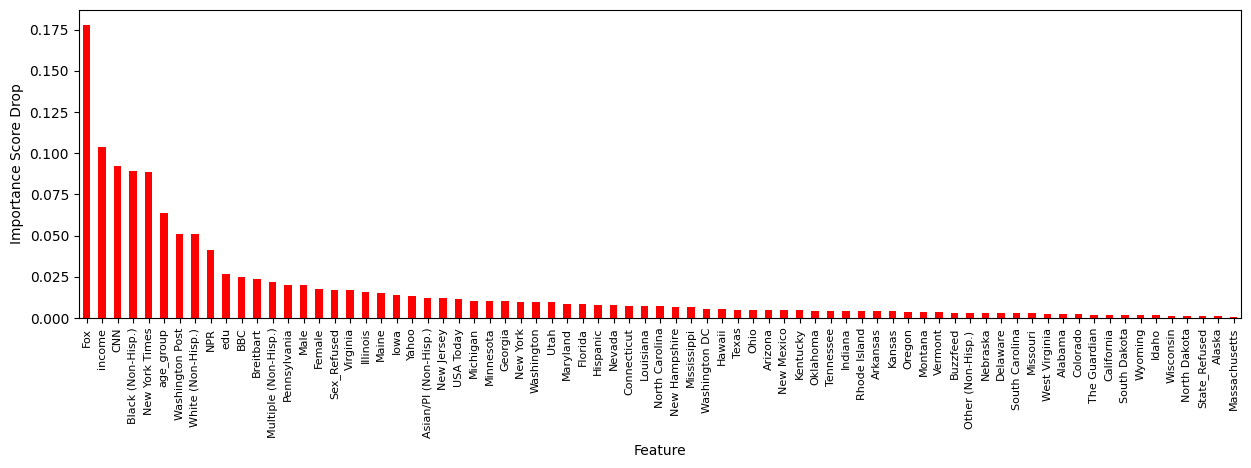

In [14]:
# Compare feature importance before & after shuffling
importance_diff = feature_importance - feature_importance_shuffled

# Sort by absolute difference
importance_diff = importance_diff.abs().sort_values(ascending=False)

# Plot sensitivity of features
plt.figure(figsize=(15, 4))
importance_diff.plot(kind='bar', color='red')
plt.xlabel('Feature')
plt.ylabel('Importance Score Drop')
plt.xticks(fontsize=8)
plt.show()

In [15]:
os.makedirs('table_source', exist_ok=True)
feature_importance.to_csv('table_source/news_usage_feature_importance.csv', index=False)  
feature_importance_shuffled.to_csv('table_source/news_usage_feature_importance_shuffled.csv', index=False) 
importance_diff.to_csv('table_source/news_usage_importance_diff.csv', index=False) 

In [16]:
best_rf.fit(X_train, y_train)
# Predict and evaluate on the test set
y_test_pred = best_rf.predict(X_test)
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
test_report_df = pd.DataFrame(test_report).T
test_report_df

Test Accuracy: 0.7394312067640276


,precision,recall,f1-score,support
1,0.757218,0.789330,0.772940,731.000000
2,0.714286,0.675439,0.694319,570.000000
accuracy,0.739431,0.739431,0.739431,0.739431
macro avg,0.735752,0.732384,0.733630,1301.000000
weighted avg,0.738408,0.739431,0.738495,1301.000000


In [17]:
# Calculate 95% confidence interval for the test accuracy
n = len(y_test)
z = norm.ppf(0.975)  # 1.96 for 95% confidence
se = np.sqrt((test_accuracy * (1 - test_accuracy)) / n)
margin_of_error = z * se

print(f"Test Accuracy: {test_accuracy:.3f} ± {margin_of_error:.3f} (95% CI)")
print(f"95% CI: [{test_accuracy - margin_of_error:.3f}, {test_accuracy + margin_of_error:.3f}]")

Test Accuracy: 0.739 ± 0.024 (95% CI)
95% CI: [0.716, 0.763]
